In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [61]:
'''
LightGBM module

the module can be use for both classification and regression problem the appropriate objective method should be defined.
more information can be find here
https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst
http://lightgbm.readthedocs.io/en/latest/Python-API.html

AT THE MOMENT
User can NOT define a customized objective function and evaluation function

optimization with grid search is easy first make a grid

make_grid(learning_rate = [1, 2, 3], max_depth = [3, 4, 5])

then run the optimization
optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2)

to see the result and select best parameters
scores()


get the importance features and plot them is another awesome part of this module :)

get_importance()
plot_importance()

comparision of XGB and LGB
https://sites.google.com/view/lauraepp/parameters

used skopt module for bayesian optimization

'''
import lightgbm as lgb
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

color = sns.color_palette()

class LGB(object):
    def __init__(self, num_boost_round=10, objective=None, metric='None', feval=None, fobj=None, **kwargs):
        self.clf = None
        self.grid_params = None
        self.result = None
        self.grid_list = []
        self.feval = feval
        self.fobj = fobj
        self.num_boost_round = num_boost_round
        self.params = kwargs
        if not fobj:
            if objective:
                print("Built a LightGBM with defiend objective function")
                self.params.update({'boosting_type': 'gbdt', 'objective' : objective, 'metric' : metric})               
            else:
                print("Built a LightGBM with default objective")
                self.params.update({'boosting_type': 'gbdt', 'objective' : 'regression_l2', 'metric' : 'l1'})
            
        print(self.params)
        
    def set_params(self, print_out=True, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        self.params.update(params)
        if print_out:
            print(self.params)
            
    def set_params_scores(self, dt, N=1):
        print(self.params)
        params = dt.iloc[N].to_dict()
        if 'score' in params:
            del params['score']
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
#            del params['num_boost_round']
        self.params.update(params)
        print(self.params)
        
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y)
        self.clf = lgb.train(params=self.params, train_set=dtrain, num_boost_round=num_boost_round)
        
    def predict(self, X):
        return self.clf.predict(X)
    
    def get_params(self, deep=True):
        return self.params

    def get_importance(self):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val
        return importance

    def plot_importance(self, N = 10):
        importance = {}
        for key, val in zip(self.clf.feature_name(), self.clf.feature_importance()):
            importance[key] = val

        import operator
        importance = sorted(importance.items(), key=operator.itemgetter(1))

        importance_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        importance_df['fscore'] = importance_df['fscore'] / importance_df['fscore'].sum()

        plt.figure()
        importance_df[-N:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))
        plt.title('XGBoost Feature Importance')
        plt.xlabel('relative importance')
        plt.ylabel('')
        plt.show()
    
    def fit_eval(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 print_out=False):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y)
        dtest = lgb.Dataset(X_test, y_test, reference=dtrain)
        
        if self.feval == None:
            self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
        else:
            self.params.update({'metric': 'None'})
            self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
#                             feval = self.evalerror, 
                             early_stopping_rounds = early_stopping)

        if print_out:
            print("Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])
            return
        else:
            return self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
        
    def fit_cv(self, X, y, cv, verbose_eval = False, num_boost_round = None, early_stopping = 5,
                 print_out=False):
        
        num_boost_round = num_boost_round or self.num_boost_round
        scores = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y)):
            dtrain = lgb.Dataset(X[train_index], label=y[train_index])
            dtest = lgb.Dataset(X[test_index], label=y[test_index])

            if self.feval == None:
                self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
                             early_stopping_rounds = early_stopping)
            else:
                self.params.update({'metric': 'None'})
                self.clf = lgb.train(params = self.params, train_set = dtrain, num_boost_round = num_boost_round,
                             valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                             verbose_eval = verbose_eval,
#                             feval = self.evalerror, 
                             early_stopping_rounds = early_stopping)
            
            scores.append(self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]])
            
            if print_out:
                print("Kfold: ", i, "Number of iteration: ", self.clf.best_iteration, " Score: ", self.clf.best_score['valid'])

        if not print_out:
            return np.mean(scores)

        
    def grid(self, keys, comb, it=0):
        if len(keys) == it:
            return

        for x in self.grid_params[keys[it]]:
            comb.append(x)
            self.grid(keys, comb, it+1)
            if len(comb) == len(keys):
                self.grid_list.append(comb[:])
            comb.pop()
    
    def make_grid(self, **kwargs):
        self.grid_list = []
        self.grid_params = kwargs
        print(self.params)
        print(self.grid_params)
        self.grid(list(self.grid_params.keys()), [])
        print("Number of iteration for Optimization: ", len(self.grid_list))
        
    def optimization(self, X, y, X_test, y_test, verbose_eval = False, num_boost_round = None, early_stopping = 2):
        num_boost_round = num_boost_round or self.num_boost_round
        dtrain = lgb.Dataset(X, label=y)
        dtest = lgb.Dataset(X_test, y_test, reference=dtrain)

        col = list(self.grid_params.keys()) + ['iterations', 'score']
        self.result = pd.DataFrame(columns=col)

        for i in tqdm(range(len(self.grid_list))):
            temp = {}
            for j, key in enumerate(self.grid_params.keys()):
                temp[key] = self.grid_list[i][j]
            temp.update(self.params)

            if self.feval == None:
                self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
                                 valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                                 verbose_eval = False,
                                 early_stopping_rounds = early_stopping)
            else:
                self.params.update({'metric': 'None'})
                self.clf = lgb.train(params = temp, train_set = dtrain, num_boost_round = num_boost_round,
                                 valid_sets = [dtrain, dtest], valid_names = ['train', 'valid'],
                                 verbose_eval = False,
    #                             feval = self.evalerror, 
                                 early_stopping_rounds = early_stopping)
            
            score = self.clf.best_score['valid'][list(self.clf.best_score['valid'].keys())[0]]
            self.result = self.result.append(pd.DataFrame([self.grid_list[i] + [self.clf.best_iteration, score]], columns=col))
    
    def scores(self, N=4):
        return self.result.sort_values("score")[:N]
    
    def bayesian(self, X, y, X_test=None, y_test=None, cv=None, nstopping = 5, ncalls = 10, seed=0,
                 warrning=False, **kwargs):
        if not warrning:
            print("Ignore UserWarning")
            warnings.filterwarnings("ignore")
        if cv:
            print("CV optimization")
        print(kwargs)
        space = []
        for key, val in kwargs.items():
            if key == "learning_rate":
                space.append(Real(val[0], val[1], "log-uniform", name='learning_rate'))
            elif key == "num_leaves":
                space.append(Integer(val[0], val[1], name='num_leaves'))
            elif key == 'subsample': 
                space.append(Real(val[0], val[1], "uniform", name='subsample'))
            elif key == 'colsample_bytree': 
                space.append(Real(val[0], val[1], "uniform", name='colsample_bytree'))
            elif key == "reg_lambda":
                space.append(Real(val[0], val[1], "uniform", name='reg_lambda'))
            elif key == "reg_alpha":
                space.append(Real(val[0], val[1], "uniform", name='reg_alpha'))
            elif key == "min_split_gain":
                space.append(Real(val[0], val[1], "uniform", name='min_split_gain'))
            elif key == "min_child_samples":
                space.append(Integer(val[0], val[1], name='min_child_samples'))
            elif key == "scale_pos_weight":
                space.append(Integer(val[0], val[1], name='scale_pos_weight'))
            else:
                print("Error: Invalid parameter")
        
        print(space)
                
                
        @use_named_args(space)
        def objective(**params):
            self.set_params(print_out=False, **params)
            
            if cv:
                return self.fit_cv(X, y, cv, verbose_eval = False, num_boost_round = self.num_boost_round, 
                                 early_stopping = nstopping)
            else:
                return self.fit_eval(X, y, X_test, y_test, verbose_eval = False, num_boost_round = self.num_boost_round, 
                                 early_stopping = nstopping)
        

        res_gp = gp_minimize(objective, space, n_calls = ncalls, random_state=seed)
    
        plot_convergence(res_gp)
        
        col = list(kwargs.keys()) + ['score']
        self.result = pd.DataFrame(columns=col)
        
        for val, score in zip(res_gp.x_iters, res_gp.func_vals):
            self.result = self.result.append(pd.DataFrame([val + [score]], columns=col))

# Create data set

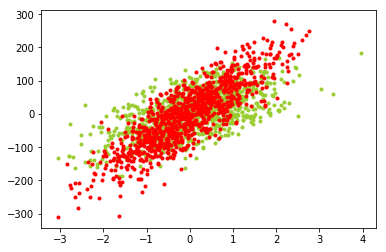

In [62]:
# create a dataset for regression problem
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=1)

X1, y1, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=50,
                                      coef=True, random_state=0)

plt.scatter(X, y, color='yellowgreen', marker='.',
            label='Inliers')
#plt.show()

plt.scatter(X1, y1, color='red', marker='.',
            label='Inliers')
plt.show()

# Simple test

In [63]:
model = LGB(boosting_type = 'gbdt', objective = 'regression', metric = {'l1', 'l2_root'}, num_boost_round=200)

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}}


In [64]:
model.fit_eval(X, y, X1, y1, verbose_eval=5, num_boost_round=100)

Training until validation scores don't improve for 5 rounds.
[5]	train's l1: 42.8796	train's rmse: 53.2341	valid's l1: 65.8375	valid's rmse: 82.7214
[10]	train's l1: 40.0536	train's rmse: 49.525	valid's l1: 60.825	valid's rmse: 76.1783
[15]	train's l1: 38.8535	train's rmse: 48.0146	valid's l1: 58.1248	valid's rmse: 72.5638
[20]	train's l1: 38.2787	train's rmse: 47.3325	valid's l1: 56.6209	valid's rmse: 70.6381
[25]	train's l1: 37.9908	train's rmse: 46.9708	valid's l1: 55.7476	valid's rmse: 69.4726
[30]	train's l1: 37.7405	train's rmse: 46.7126	valid's l1: 55.279	valid's rmse: 68.8418
[35]	train's l1: 37.5669	train's rmse: 46.519	valid's l1: 54.9603	valid's rmse: 68.4425
[40]	train's l1: 37.4325	train's rmse: 46.346	valid's l1: 54.8508	valid's rmse: 68.3074
[45]	train's l1: 37.3055	train's rmse: 46.1921	valid's l1: 54.797	valid's rmse: 68.2343
[50]	train's l1: 37.1963	train's rmse: 46.0528	valid's l1: 54.7923	valid's rmse: 68.1957
Early stopping, best iteration is:
[46]	train's l1: 37.2

54.761868509626531

In [65]:
pred = model.predict(X1)

In [66]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred, y1)

54.761868519182244

# Grid Search

In [67]:
model.make_grid(learning_rate = [0.1, 0.02], num_leaves = [20, 25, 30])

{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}, 'verbose': 1}
{'learning_rate': [0.1, 0.02], 'num_leaves': [20, 25, 30]}
Number of iteration for Optimization:  6


In [9]:
model.optimization(X, y, X1, y1, verbose_eval=5, num_boost_round=100)

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]


In [10]:
model.scores()

,learning_rate,num_leaves,iterations,score
0,0.10,20,43,54.669652
0,0.10,25,46,54.727353
0,0.10,30,41,54.811202
0,0.02,20,100,56.623674


# Bayesin minimization

In [38]:
model = LGB(boosting_type = 'gbdt', objective = 'regression', metric = {'l1', 'l2_root'}, num_boost_round=200)

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}}


Ignore UserWarning
{'learning_rate': [0.01, 0.05], 'num_leaves': [20, 50], 'subsample': [0.5, 1], 'colsample_bytree': [0.5, 1], 'min_child_samples': [1, 20], 'min_split_gain': [0, 10], 'reg_lambda': [0, 10], 'reg_alpha': [0, 10]}
[Real(low=0.01, high=0.05, prior='log-uniform', transform='identity'), Integer(low=20, high=50), Real(low=0.5, high=1, prior='uniform', transform='identity'), Real(low=0.5, high=1, prior='uniform', transform='identity'), Integer(low=1, high=20), Real(low=0, high=10, prior='uniform', transform='identity'), Real(low=0, high=10, prior='uniform', transform='identity'), Real(low=0, high=10, prior='uniform', transform='identity')]


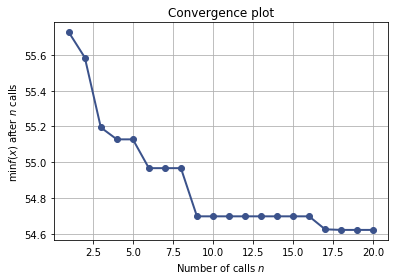

In [39]:
model.bayesian(X, y, X1, y1, ncalls=20, nstopping=5, seed=10, 
               learning_rate = [0.01, 0.05], num_leaves = [20, 50], subsample = [0.5, 1],
               colsample_bytree = [0.5, 1], min_child_samples = [1, 20], min_split_gain = [0, 10],
               reg_lambda = [0, 10], reg_alpha = [0, 10])

In [41]:
model.scores()

,learning_rate,num_leaves,subsample,colsample_bytree,min_child_samples,min_split_gain,reg_lambda,reg_alpha,score
0,0.026196,20,0.724260,0.709784,15,4.410210,0.000000,2.593946,54.621810
0,0.025350,20,0.600880,0.722925,16,2.424114,1.222015,4.259453,54.625205
0,0.026851,20,0.501951,0.669358,15,1.439753,0.000000,0.000000,54.630397
0,0.025318,20,0.527205,0.503743,16,10.000000,0.000000,3.733675,54.657719


In [42]:
dt = model.scores()

In [44]:
model = LGB(boosting_type = 'gbdt', objective = 'regression', metric = {'l1', 'l2_root'}, num_boost_round=200)

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}}


In [45]:
model.set_params_scores(dt, N=2)

{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}}
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2_root', 'l1'}, 'learning_rate': 0.026851117010767575, 'num_leaves': 20, 'subsample': 0.50195065985466703, 'colsample_bytree': 0.6693579118628703, 'min_child_samples': 15, 'min_split_gain': 1.4397532595046498, 'reg_lambda': 0.0, 'reg_alpha': 0.0}


In [59]:
model = LGB(boosting_type = 'gbdt', objective = 'regression', metric = {'l1', 'l2_root'}, num_boost_round=200, verbose=-1)

Built a LightGBM with defiend objective function
{'boosting_type': 'gbdt', 'verbose': -1, 'objective': 'regression', 'metric': {'l2_root', 'l1'}}


In [60]:
model.fit_eval(X, y, X1, y1, verbose_eval=False)

{'boosting_type': 'gbdt', 'verbose': -1, 'objective': 'regression', 'metric': {'l2_root', 'l1'}}
{'boosting_type': 'gbdt', 'verbose': -1, 'objective': 'regression', 'metric': {'l2_root', 'l1'}}


54.761868509626538

In [55]:
model.get_params()

{'boosting_type': 'gbdt',
 'metric': {'l1', 'l2_root'},
 'objective': 'regression',
 'verbose': 1}